In [9]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [10]:
#Carico il dataset

data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

data = data.sample(frac=1, random_state=45).reset_index(drop=True) #shuffle

print("Shape del dataset : ", data.shape)


Shape del dataset :  (13451, 22)


Total :  13451
Normal :  7500
Malicious :  5951


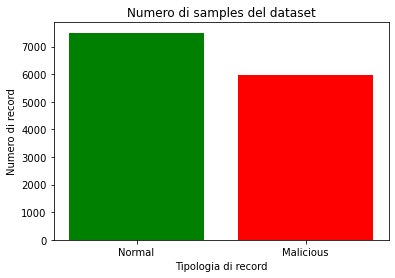

In [11]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

R2L :  381      Normal :  7500
U2R :  50       DOS :  5000
Probe :  520


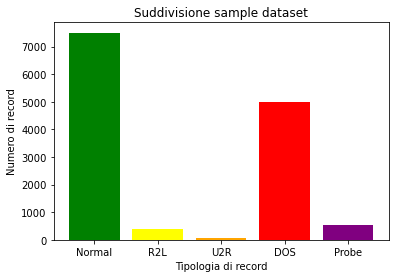

In [12]:
#plot che mi mostra la suddivisione tra i 4 attacchi

r2l_flows_count = len(data[data.result == "r2l"])
u2r_flows_count = len(data[data.result == "u2r"])
dos_flows_count = len(data[data.result == "dos"])
probe_flows_count = len(data[data.result == "probe"])

print("R2L : ",r2l_flows_count,"     Normal : ",normal_flows_count)
print("U2R : ",u2r_flows_count,"      DOS : ",dos_flows_count)
print("Probe : ",probe_flows_count)

left = [1, 1.5, 2, 2.5, 3] 
  
# heights of bars 
height = [normal_flows_count, r2l_flows_count, u2r_flows_count, dos_flows_count, probe_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'R2L', "U2R", "DOS", "Probe"] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green','yellow', 'orange', 'red', 'purple']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Suddivisione sample dataset') 
  
plt.show() 

In [13]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [14]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')
data.flag.replace(flag_list, range(len(flag_list)), inplace=True)

encode_numeric_zscore(data, 'duration')
encode_numeric_zscore(data, 'src_bytes')
encode_numeric_zscore(data, 'dst_bytes')
encode_numeric_zscore(data, 'land')
encode_numeric_zscore(data, 'land')
encode_numeric_zscore(data, 'wrong_fragment')
encode_numeric_zscore(data, 'urgent')
encode_numeric_zscore(data, 'hot')
encode_numeric_zscore(data, 'num_failed_logins')
encode_numeric_zscore(data, 'logged_in')
encode_numeric_zscore(data, 'num_compromised')
encode_numeric_zscore(data, 'root_shell')
encode_numeric_zscore(data, 'su_attempted')
encode_numeric_zscore(data, 'num_root')
encode_numeric_zscore(data, 'num_file_creations')
encode_numeric_zscore(data, 'num_shells')
encode_numeric_zscore(data, 'num_access_files')
encode_numeric_zscore(data, 'is_guest_login')
encode_numeric_zscore(data, 'count')

Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [15]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = data['result'].copy().values.reshape((data.shape[0], 1))
df_label = pd.DataFrame(label)
data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        data[i] = data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        data[i] = data[i].map(lambda x: std if x > std else x)
sc.fit(data[['duration', 'src_bytes', 'dst_bytes']].values)
data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Conversione feature "count" in linguaggio macchina . . .')
sc.fit(data[['count']].values.astype(np.float32))
data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Conversione indici 1,2,3 in linguaggio macchina . . .')
enc.fit(data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(data[['protocol_type','service','flag']].values).toarray()

print('Rimuovo le features di indici 1,2,3 e concateno un hot encoder array')
data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print("")
print("")
print('Final shape of data:', data_final.shape)
print("")
print("")

Conversione feature "count" in linguaggio macchina . . .
Conversione indici 1,2,3 in linguaggio macchina . . .
Rimuovo le features di indici 1,2,3 e concateno un hot encoder array


Final shape of data: (13451, 95)




Epoch 1/15
47/47 [==============================] - 12s 264ms/step - loss: 0.1409 - val_loss: 0.0731
Epoch 2/15
47/47 [==============================] - 12s 261ms/step - loss: 0.0827 - val_loss: 0.0350
Epoch 3/15
47/47 [==============================] - 14s 292ms/step - loss: 0.0669 - val_loss: 0.0318
Epoch 4/15
47/47 [==============================] - 14s 289ms/step - loss: 0.0617 - val_loss: 0.0311
Epoch 5/15
47/47 [==============================] - 13s 281ms/step - loss: 0.0562 - val_loss: 0.0329
Epoch 6/15
47/47 [==============================] - 15s 312ms/step - loss: 0.0448 - val_loss: 0.0277
Epoch 7/15
47/47 [==============================] - 13s 281ms/step - loss: 0.0340 - val_loss: 0.0254
Epoch 8/15
47/47 [==============================] - 14s 295ms/step - loss: 0.0319 - val_loss: 0.0232
Epoch 9/15
47/47 [==============================] - 13s 276ms/step - loss: 0.0306 - val_loss: 0.0218
Epoch 10/15
47/47 [==============================] - 13s 276ms/step - loss: 0.0301 - val_lo

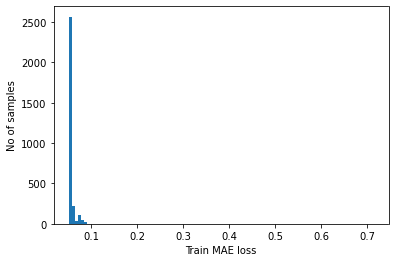

Reconstruction error threshold:  0.054741662


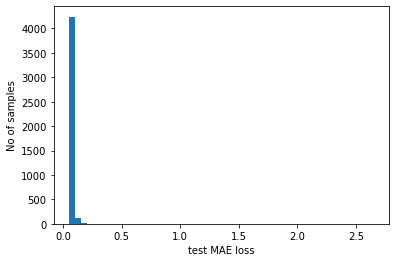

Number di sample normali rilevati:  3195
Numero di sample normali rivelati erroneamente:  421 (FP)
Numero di sample normali rilevati correttamente:  2774 (TP)
Numero di sample normali non rivelati (considerati anomalie):  257 (FN)
Numero di sample anomali rivelati correttamente 928 (TN)
Numero di sample anomali scambiati per normali 421 (FP)

Numero di sample anomali U2R rilevati correttamente:  0 (TN)
Numero di sample anomali U2R considerati Normali : 22 (FP)
Numero di sample anomali R2L rilevati correttamente:  2 (TN)
Numero di sample anomali R2L considerati normali : 134 (FP)
Numero di sample anomali Probe rilevati correttamente:  152 (TN)
Numero di sample anomali Probe considerati normali : 39 (FP)
Numero di sample anomali Dos rilevati correttamente:  774 (TN)
Numero di sample anomali Dos considerati normali : 226 (FP)

### 0 Anomaly / 1 Normal ###


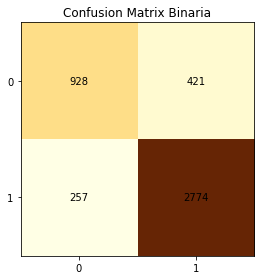

          predicted labels  
0 :
             precision:  0.783
             recall:     0.688


1 :
             precision:  0.868
             recall:     0.915


Avg precision:     0.826
Avg weight precision:     0.842
Avg recall:     0.802
Avg weight recall:     0.845

Accuracy:  0.84521
Epoch 1/15
47/47 [==============================] - 14s 288ms/step - loss: 0.1262 - val_loss: 0.0737
Epoch 2/15
47/47 [==============================] - 13s 277ms/step - loss: 0.0810 - val_loss: 0.0294
Epoch 3/15
47/47 [==============================] - 14s 298ms/step - loss: 0.0550 - val_loss: 0.0218
Epoch 4/15
47/47 [==============================] - 13s 280ms/step - loss: 0.0420 - val_loss: 0.0222
Epoch 5/15
47/47 [==============================] - 14s 295ms/step - loss: 0.0353 - val_loss: 0.0202
Epoch 6/15
47/47 [==============================] - 14s 291ms/step - loss: 0.0329 - val_loss: 0.0142
Epoch 7/15
47/47 [==============================] - 13s 283ms/step - loss: 0.0313 - val_loss: 0.0144


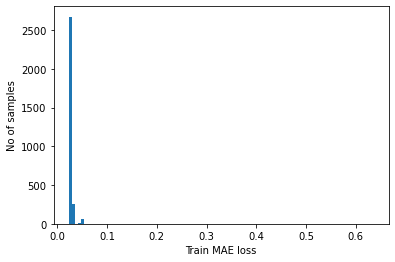

Reconstruction error threshold:  0.025747357


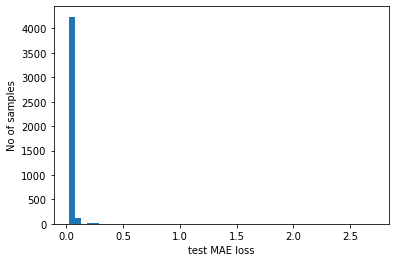

Number di sample normali rilevati:  3348
Numero di sample normali rivelati erroneamente:  438 (FP)
Numero di sample normali rilevati correttamente:  2910 (TP)
Numero di sample normali non rivelati (considerati anomalie):  121 (FN)
Numero di sample anomali rivelati correttamente 911 (TN)
Numero di sample anomali scambiati per normali 438 (FP)

Numero di sample anomali U2R rilevati correttamente:  0 (TN)
Numero di sample anomali U2R considerati Normali : 22 (FP)
Numero di sample anomali R2L rilevati correttamente:  1 (TN)
Numero di sample anomali R2L considerati normali : 135 (FP)
Numero di sample anomali Probe rilevati correttamente:  136 (TN)
Numero di sample anomali Probe considerati normali : 55 (FP)
Numero di sample anomali Dos rilevati correttamente:  774 (TN)
Numero di sample anomali Dos considerati normali : 226 (FP)

### 0 Anomaly / 1 Normal ###


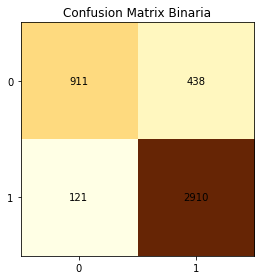

          predicted labels  
0 :
             precision:  0.883
             recall:     0.675


1 :
             precision:  0.869
             recall:     0.960


Avg precision:     0.876
Avg weight precision:     0.873
Avg recall:     0.818
Avg weight recall:     0.872

Accuracy:  0.87237
Epoch 1/15
47/47 [==============================] - 13s 279ms/step - loss: 0.1655 - val_loss: 0.0732
Epoch 2/15
47/47 [==============================] - 13s 280ms/step - loss: 0.0917 - val_loss: 0.0408
Epoch 3/15
47/47 [==============================] - 13s 280ms/step - loss: 0.0685 - val_loss: 0.0526
Epoch 4/15
47/47 [==============================] - 13s 279ms/step - loss: 0.0634 - val_loss: 0.0502
Epoch 5/15
47/47 [==============================] - 13s 275ms/step - loss: 0.0587 - val_loss: 0.0545
Epoch 6/15
47/47 [==============================] - 13s 277ms/step - loss: 0.0548 - val_loss: 0.0811
Epoch 7/15
47/47 [==============================] - 13s 279ms/step - loss: 0.0487 - val_loss: 0.1502


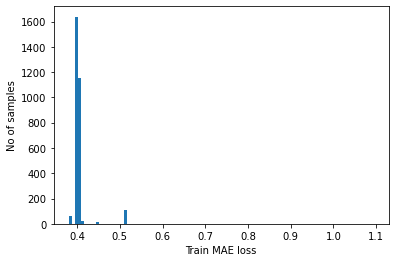

Reconstruction error threshold:  0.40370384


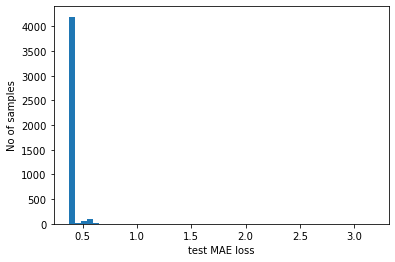

Number di sample normali rilevati:  588
Numero di sample normali rivelati erroneamente:  464 (FP)
Numero di sample normali rilevati correttamente:  124 (TP)
Numero di sample normali non rivelati (considerati anomalie):  2907 (FN)
Numero di sample anomali rivelati correttamente 885 (TN)
Numero di sample anomali scambiati per normali 464 (FP)

Numero di sample anomali U2R rilevati correttamente:  7 (TN)
Numero di sample anomali U2R considerati Normali : 15 (FP)
Numero di sample anomali R2L rilevati correttamente:  24 (TN)
Numero di sample anomali R2L considerati normali : 112 (FP)
Numero di sample anomali Probe rilevati correttamente:  115 (TN)
Numero di sample anomali Probe considerati normali : 76 (FP)
Numero di sample anomali Dos rilevati correttamente:  739 (TN)
Numero di sample anomali Dos considerati normali : 261 (FP)

### 0 Anomaly / 1 Normal ###


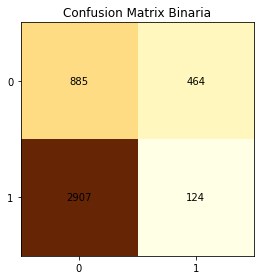

          predicted labels  
0 :
             precision:  0.233
             recall:     0.656


1 :
             precision:  0.211
             recall:     0.041


Avg precision:     0.222
Avg weight precision:     0.218
Avg recall:     0.348
Avg weight recall:     0.230

Accuracy:  0.23037
Epoch 1/15
47/47 [==============================] - 14s 303ms/step - loss: 0.1473 - val_loss: 0.0776
Epoch 2/15
47/47 [==============================] - 15s 312ms/step - loss: 0.0898 - val_loss: 0.0388
Epoch 3/15
47/47 [==============================] - 13s 279ms/step - loss: 0.0707 - val_loss: 0.0359
Epoch 4/15
47/47 [==============================] - 14s 291ms/step - loss: 0.0679 - val_loss: 0.0322
Epoch 5/15
47/47 [==============================] - 13s 285ms/step - loss: 0.0637 - val_loss: 0.0259
Epoch 6/15
47/47 [==============================] - 13s 280ms/step - loss: 0.0564 - val_loss: 0.0246
Epoch 7/15
47/47 [==============================] - 13s 277ms/step - loss: 0.0458 - val_loss: 0.0273


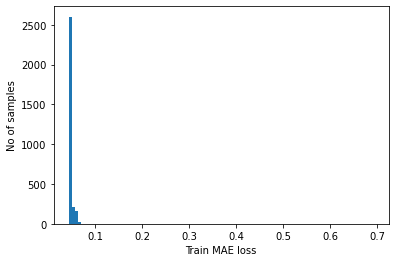

Reconstruction error threshold:  0.048397638


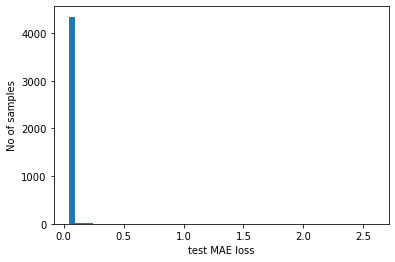

Number di sample normali rilevati:  3168
Numero di sample normali rivelati erroneamente:  390 (FP)
Numero di sample normali rilevati correttamente:  2778 (TP)
Numero di sample normali non rivelati (considerati anomalie):  253 (FN)
Numero di sample anomali rivelati correttamente 959 (TN)
Numero di sample anomali scambiati per normali 390 (FP)

Numero di sample anomali U2R rilevati correttamente:  0 (TN)
Numero di sample anomali U2R considerati Normali : 22 (FP)
Numero di sample anomali R2L rilevati correttamente:  8 (TN)
Numero di sample anomali R2L considerati normali : 128 (FP)
Numero di sample anomali Probe rilevati correttamente:  174 (TN)
Numero di sample anomali Probe considerati normali : 17 (FP)
Numero di sample anomali Dos rilevati correttamente:  777 (TN)
Numero di sample anomali Dos considerati normali : 223 (FP)

### 0 Anomaly / 1 Normal ###


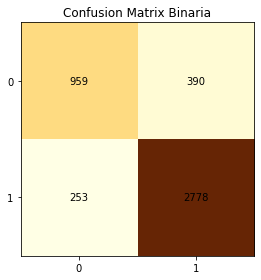

          predicted labels  
0 :
             precision:  0.791
             recall:     0.711


1 :
             precision:  0.877
             recall:     0.917


Avg precision:     0.834
Avg weight precision:     0.851
Avg recall:     0.814
Avg weight recall:     0.853

Accuracy:  0.85320
Epoch 1/15
47/47 [==============================] - 14s 288ms/step - loss: 0.2368 - val_loss: 0.0759
Epoch 2/15
47/47 [==============================] - 14s 308ms/step - loss: 0.1092 - val_loss: 0.0737
Epoch 3/15
47/47 [==============================] - 14s 295ms/step - loss: 0.1085 - val_loss: 0.0734
Epoch 4/15
47/47 [==============================] - 15s 311ms/step - loss: 0.1079 - val_loss: 0.0708
Epoch 5/15
47/47 [==============================] - 13s 281ms/step - loss: 0.0835 - val_loss: 0.0390
Epoch 6/15
47/47 [==============================] - 13s 283ms/step - loss: 0.0708 - val_loss: 0.0348
Epoch 7/15
47/47 [==============================] - 13s 281ms/step - loss: 0.0665 - val_loss: 0.0279


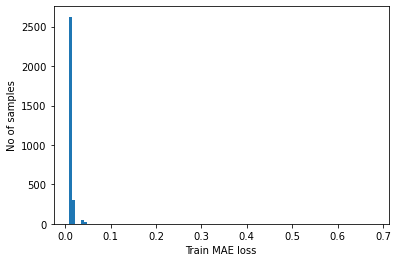

Reconstruction error threshold:  0.009474794


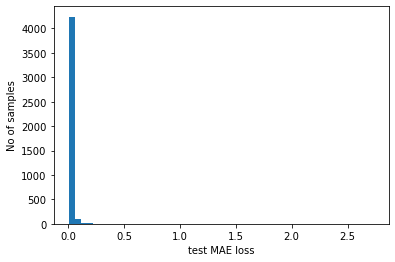

Number di sample normali rilevati:  3182
Numero di sample normali rivelati erroneamente:  406 (FP)
Numero di sample normali rilevati correttamente:  2776 (TP)
Numero di sample normali non rivelati (considerati anomalie):  255 (FN)
Numero di sample anomali rivelati correttamente 943 (TN)
Numero di sample anomali scambiati per normali 406 (FP)

Numero di sample anomali U2R rilevati correttamente:  0 (TN)
Numero di sample anomali U2R considerati Normali : 22 (FP)
Numero di sample anomali R2L rilevati correttamente:  1 (TN)
Numero di sample anomali R2L considerati normali : 135 (FP)
Numero di sample anomali Probe rilevati correttamente:  159 (TN)
Numero di sample anomali Probe considerati normali : 32 (FP)
Numero di sample anomali Dos rilevati correttamente:  783 (TN)
Numero di sample anomali Dos considerati normali : 217 (FP)

### 0 Anomaly / 1 Normal ###


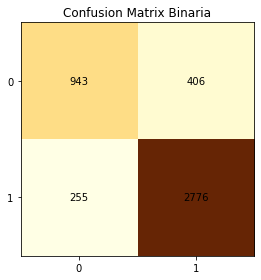

          predicted labels  
0 :
             precision:  0.787
             recall:     0.699


1 :
             precision:  0.872
             recall:     0.916


Avg precision:     0.830
Avg weight precision:     0.846
Avg recall:     0.807
Avg weight recall:     0.849

Accuracy:  0.84909
Epoch 1/15
47/47 [==============================] - 13s 278ms/step - loss: 0.1354 - val_loss: 0.0756
Epoch 2/15
47/47 [==============================] - 13s 280ms/step - loss: 0.1099 - val_loss: 0.0751
Epoch 3/15
47/47 [==============================] - 13s 278ms/step - loss: 0.1098 - val_loss: 0.0750
Epoch 4/15
47/47 [==============================] - 14s 288ms/step - loss: 0.1096 - val_loss: 0.0748
Epoch 5/15
47/47 [==============================] - 13s 280ms/step - loss: 0.1094 - val_loss: 0.0745
Epoch 6/15
47/47 [==============================] - 13s 277ms/step - loss: 0.1091 - val_loss: 0.0742
Epoch 7/15
47/47 [==============================] - 14s 301ms/step - loss: 0.1089 - val_loss: 0.0739


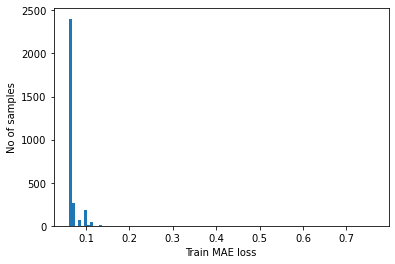

Reconstruction error threshold:  0.06736327


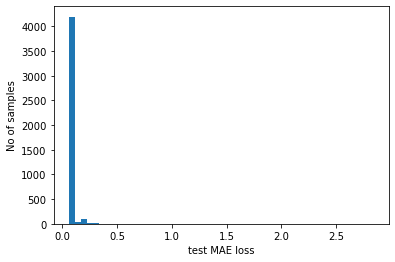

Number di sample normali rilevati:  3164
Numero di sample normali rivelati erroneamente:  385 (FP)
Numero di sample normali rilevati correttamente:  2779 (TP)
Numero di sample normali non rivelati (considerati anomalie):  252 (FN)
Numero di sample anomali rivelati correttamente 964 (TN)
Numero di sample anomali scambiati per normali 385 (FP)

Numero di sample anomali U2R rilevati correttamente:  0 (TN)
Numero di sample anomali U2R considerati Normali : 22 (FP)
Numero di sample anomali R2L rilevati correttamente:  2 (TN)
Numero di sample anomali R2L considerati normali : 134 (FP)
Numero di sample anomali Probe rilevati correttamente:  187 (TN)
Numero di sample anomali Probe considerati normali : 4 (FP)
Numero di sample anomali Dos rilevati correttamente:  775 (TN)
Numero di sample anomali Dos considerati normali : 225 (FP)

### 0 Anomaly / 1 Normal ###


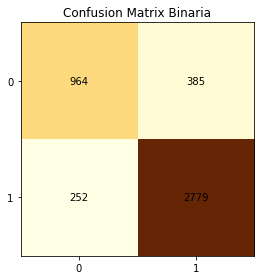

          predicted labels  
0 :
             precision:  0.793
             recall:     0.715


1 :
             precision:  0.878
             recall:     0.917


Avg precision:     0.836
Avg weight precision:     0.852
Avg recall:     0.816
Avg weight recall:     0.855

Accuracy:  0.85457
Epoch 1/15
47/47 [==============================] - 14s 291ms/step - loss: 0.1173 - val_loss: 0.0752
Epoch 2/15
47/47 [==============================] - 14s 291ms/step - loss: 0.1095 - val_loss: 0.0742
Epoch 3/15
47/47 [==============================] - 13s 281ms/step - loss: 0.0998 - val_loss: 0.0574
Epoch 4/15
47/47 [==============================] - 14s 298ms/step - loss: 0.0716 - val_loss: 0.0403
Epoch 5/15
47/47 [==============================] - 14s 295ms/step - loss: 0.0567 - val_loss: 0.0413
Epoch 6/15
47/47 [==============================] - 14s 296ms/step - loss: 0.0493 - val_loss: 0.0239
Epoch 7/15
47/47 [==============================] - 13s 280ms/step - loss: 0.0379 - val_loss: 0.0183


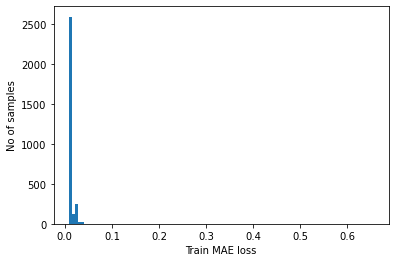

Reconstruction error threshold:  0.013133193


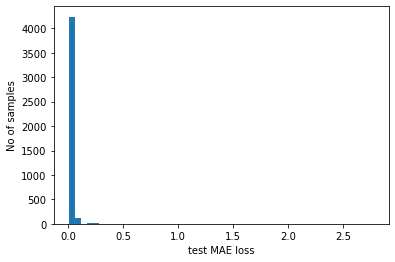

Number di sample normali rilevati:  3176
Numero di sample normali rivelati erroneamente:  402 (FP)
Numero di sample normali rilevati correttamente:  2774 (TP)
Numero di sample normali non rivelati (considerati anomalie):  257 (FN)
Numero di sample anomali rivelati correttamente 947 (TN)
Numero di sample anomali scambiati per normali 402 (FP)

Numero di sample anomali U2R rilevati correttamente:  0 (TN)
Numero di sample anomali U2R considerati Normali : 22 (FP)
Numero di sample anomali R2L rilevati correttamente:  2 (TN)
Numero di sample anomali R2L considerati normali : 134 (FP)
Numero di sample anomali Probe rilevati correttamente:  177 (TN)
Numero di sample anomali Probe considerati normali : 14 (FP)
Numero di sample anomali Dos rilevati correttamente:  768 (TN)
Numero di sample anomali Dos considerati normali : 232 (FP)

### 0 Anomaly / 1 Normal ###


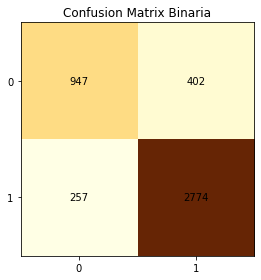

          predicted labels  
0 :
             precision:  0.787
             recall:     0.702


1 :
             precision:  0.873
             recall:     0.915


Avg precision:     0.830
Avg weight precision:     0.847
Avg recall:     0.809
Avg weight recall:     0.850

Accuracy:  0.84954
Epoch 1/15
47/47 [==============================] - 13s 277ms/step - loss: 0.1247 - val_loss: 0.0712
Epoch 2/15
47/47 [==============================] - 13s 280ms/step - loss: 0.0784 - val_loss: 0.0359
Epoch 3/15
47/47 [==============================] - 13s 280ms/step - loss: 0.0678 - val_loss: 0.0329
Epoch 4/15
47/47 [==============================] - 13s 278ms/step - loss: 0.0653 - val_loss: 0.0309
Epoch 5/15
47/47 [==============================] - 13s 277ms/step - loss: 0.0590 - val_loss: 0.0269
Epoch 6/15
47/47 [==============================] - 13s 282ms/step - loss: 0.0453 - val_loss: 0.0282
Epoch 7/15
47/47 [==============================] - 13s 281ms/step - loss: 0.0355 - val_loss: 0.0369


KeyboardInterrupt: 

In [16]:

dos_data = data_final[data_final[94] == "dos"] #prendo solo gli attacchi "dos" 



for i in range(10):
    #60% per il train / 20% per la validation / 20% per il test
    data_train, data_val, data_test = np.split(dos_data, [int(.6*len(dos_data)), int(.8*len(dos_data))])

    x_train = data_train.drop([94],axis=1) #rimuove la colonna result dal dataframe
    x_val = data_val.drop([94], axis=1) #rimuove il label

    x_train_arr = np.asarray(x_train).astype(np.float32)
    x_train_arr = x_train_arr.reshape(x_train_arr.shape[0],x_train_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

    x_val_arr = np.asarray(x_val).astype(np.float32)
    x_val_arr = x_val_arr.reshape(x_val_arr.shape[0],x_val_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
    
    model = keras.Sequential(
    [
       layers.Input(shape=(x_train_arr.shape[1],x_train_arr.shape[2])),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(64),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(x_train_arr.shape[1], activation='sigmoid'),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.TimeDistributed(layers.Dense(1)),
    ]
    )

    model.compile( optimizer='adam', loss='mse')
    
    history = model.fit(
    x_train_arr,
    x_train_arr,
    epochs=15,
    batch_size=64,
    validation_data=(x_val_arr, x_val_arr),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
    )
    
    x_train_pred = model.predict(x_train_arr)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train_arr), axis=1)
    train_mae_loss = train_mae_loss.ravel() #converte l'array numpy in 1d
    train_mae_loss = np.sort(train_mae_loss) #quicksort


    train_mae_loss_len = len(train_mae_loss)
    n_index = int(0.75*train_mae_loss_len)
    plt.hist(train_mae_loss, bins=100)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    train_mae_loss_split = train_mae_loss[:n_index]
    threshold = np.max(train_mae_loss_split)
    print("Reconstruction error threshold: ", threshold)
    

    
    #data_test
    #il dataset per il test sarà formato dai 1000 sample dos prelevati precedentemente a cui aggiungerò dei sample normali
    #e di altri attacchi (non dos)
    #in particolare prelevo il 40% dei sample non dos

    not_dos_data = data_final[data_final[94] != "dos"] #prendo solo i valori non "dos"
    percentage = 40
    not_dos_data = not_dos_data.head(int(len(not_dos_data)*(percentage/100)))
    frames = [data_test, not_dos_data]
    final_test_data = pd.concat(frames)

    data_test_with_label = final_test_data.copy()
    x_test = final_test_data.drop([94],axis=1) #rimuove la colonna dei result dal datafram

    x_test_arr = np.asarray(x_test).astype(np.float32)
    x_test_arr = x_test_arr.reshape(x_test_arr.shape[0],x_test_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

    arr_test_pred = model.predict(x_test_arr)
    test_mae_loss = np.mean(np.abs(arr_test_pred - x_test_arr), axis=1)
                                       
    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()


    # Detect all the samples which are anomalies.
    not_anomalies = (test_mae_loss > threshold).tolist()
    count = 0

    u2r_rilevati = 0
    u2r_non_rilevati = 0
    r2l_rilevati = 0
    r2l_non_rilevati = 0
    probe_rilevati = 0
    probe_non_rilevati = 0
    dos_rilevati = 0
    dos_non_rilevati = 0
    normal_corretti = 0

    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    for i in not_anomalies:
        x = str(i)
        if ( x == '[True]'): #record non anomali rilevati
            if ( data_test_with_label.iloc[count][94] == "normal"):
                true_positive = true_positive + 1 #record corretti
            if ( data_test_with_label.iloc[count][94] == "u2r"): #record classificati come normali ma che sono u2r
                u2r_rilevati = u2r_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "r2l"):
                r2l_rilevati = r2l_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "probe"):
                probe_rilevati = probe_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "dos"):
                dos_rilevati = dos_rilevati + 1
        if (x == '[False]'): #record ritenuti anomali dall'autoencoder
            if ( data_test_with_label.iloc[count][94] == "u2r"):
                u2r_non_rilevati = u2r_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "r2l"):
                r2l_non_rilevati = r2l_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "probe"):
                probe_non_rilevati = probe_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "dos"):
                dos_non_rilevati = dos_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "normal"): #record classificati come anomali ma in realtà normali
                false_negative = false_negative + 1
        count = count + 1
    
    false_positive = u2r_rilevati + r2l_rilevati + dos_rilevati + probe_rilevati
    true_negative = u2r_non_rilevati + r2l_non_rilevati + dos_non_rilevati +  probe_non_rilevati
        
    print("Number di sample normali rilevati: ", np.sum(not_anomalies))
    print("Numero di sample normali rivelati erroneamente: ", false_positive,'(FP)')
    print("Numero di sample normali rilevati correttamente: ", true_positive, '(TP)')
    print("Numero di sample normali non rivelati (considerati anomalie): ", false_negative, '(FN)')
    print("Numero di sample anomali rivelati correttamente", true_negative,"(TN)")
    print("Numero di sample anomali scambiati per normali", false_positive, '(FP)')
    print("")
    print("Numero di sample anomali U2R rilevati correttamente: ", u2r_non_rilevati, '(TN)')
    print("Numero di sample anomali U2R considerati Normali :", u2r_rilevati, '(FP)')
    print("Numero di sample anomali R2L rilevati correttamente: ", r2l_non_rilevati, '(TN)')
    print("Numero di sample anomali R2L considerati normali :", r2l_rilevati, '(FP)')
    print("Numero di sample anomali Probe rilevati correttamente: ", probe_non_rilevati, '(TN)')
    print("Numero di sample anomali Probe considerati normali :", probe_rilevati, '(FP)')
    print("Numero di sample anomali Dos rilevati correttamente: ", dos_non_rilevati, "(TN)")
    print("Numero di sample anomali Dos considerati normali :", dos_rilevati, "(FP)")
    print("")

    indici_riga_colonna = ['0','1']


    values = np.array([[true_negative, false_positive],
                       [false_negative, true_positive]])

    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap='YlOrBr')

    ax.set_xticks(np.arange(len(indici_riga_colonna)))
    ax.set_yticks(np.arange(len(indici_riga_colonna)))

    ax.set_xticklabels(indici_riga_colonna)
    ax.set_yticklabels(indici_riga_colonna)

    plt.setp(ax.get_xticklabels(),
             rotation_mode="anchor")

    for i in range(len(indici_riga_colonna)):
        for j in range(len(indici_riga_colonna)):
            text = ax.text(j, i, values[i, j],
                           ha="center", va="center")

    ax.set_title("Confusion Matrix Binaria")
    fig.tight_layout()

    print("### 0 Anomaly / 1 Normal ###")
    plt.show()

    print("          predicted labels  ")

    zero_precision = true_negative/(true_negative + false_negative) 
    one_precision = true_positive/(true_positive + false_positive) 

    zero_recall = true_negative/(true_negative + false_positive)
    one_recall = true_positive/(true_positive + false_negative)

    accuracy= (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    print("0 :")
    print("             precision: ","%.3f" % zero_precision)
    print("             recall: ","   %.3f" % zero_recall)
    print("")
    print("")
    print("1 :")
    print("             precision: ","%.3f" % one_precision)
    print("             recall: ","   %.3f" % one_recall)
    print("")
    print("")
    avg_precision = (zero_precision + one_precision)/2
    avg_precision_weight = (zero_precision*(true_negative+false_positive) + one_precision*(false_negative + true_positive))/(true_negative + false_positive + false_negative + true_positive)
    avg_recall = (zero_recall + one_recall)/2
    avg_recall_weight = (zero_recall*(true_negative+false_positive) + one_recall*(false_negative + true_positive))/(true_negative + false_positive + false_negative + true_positive)
    print("Avg precision: ","   %.3f" % avg_precision)
    print("Avg weight precision: ","   %.3f" % avg_precision_weight)
    print("Avg recall: ","   %.3f" % avg_recall)
    print("Avg weight recall: ","   %.3f" % avg_recall_weight)
    print("")
    print("Accuracy: ", "%.5f" % accuracy)